In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, \
roc_auc_score, make_scorer, RocCurveDisplay, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay

from sklearn.base import BaseEstimator, ClassifierMixin
import networkx as nx

import time
import optuna
import lightgbm
from lightgbm import LGBMClassifier, train
import hnswlib
import bnlearn as bn
from scipy.stats import mode

from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [74]:
data = pd.read_csv('edu_text_recall_data.csv')
data.head()

,recall_score,higher_edu,far_from_uni,adhd,low_focus,text_complexity,age,reads_often,not_tired
0,44.934495,0,0,0,0,61.217639,18,0,0
1,40.742706,0,0,0,1,48.660947,33,0,1
2,43.284073,0,0,0,1,62.928792,37,0,1
3,37.953784,0,1,1,1,50.497331,28,0,1
4,19.755230,0,1,1,1,19.189686,16,0,0


In [75]:
train, test = train_test_split(data, test_size=0.25, random_state=666)

### Описание данных: 

1) **Зависимая переменная (непрерывная: от 0 до 100)**: Процент смысловой точности пересказа (`recall_score`) 
2) **Переменная воздействия (бинарная)**: Уровень образования (`higher_edu`)
3) **Инструментальная переменная (бинарная)**: расстояние до ближайшего университета в школьные годы (`far_from_uni`)
4) **Эндогенные переменные (бинарные)**: наличие СДВГ (`ahdh`) и концентрация (`low_focus`) <br>
5) **Контрольные переменные (2 непрерывные и 2 бинарные)**: сложность текста (Flesch-Kincaid score / `text_complexity`), возраст (`age`), частота чтения (`reads_often`), отсутствие усталости (`not_tired`) 

## Пункт 1.

**Переменные, выбранные для прогнозирования переменной воздействия:** <br>
* Инструментальная переменная `far_from_uni`, так как у человека меньше барьеров на пути к получению высшего образования.
* Эндогенные переменные `ahdh`, `low_focus`, так как если человек страдает этим, то у него могут быть проблемы с поступлением в университет и, как следствие, меньшие шансы на получение высшего образования.
* Контрольные переменные `age`, `reads_often`, так как чем больше возраст человека, тем больше у него шансов поступить в университет и получить высшее образования и чем больше человек читает, тем вероятнее он стремится к высшим благам, думает о важности интеллектуального развития и с большим рвением поступает в университет.

In [76]:
y_train, X_train = train['higher_edu'], train[['far_from_uni', 'adhd', 'low_focus', 'age', 'reads_often']]
y_test, X_test = test['higher_edu'], test[['far_from_uni', 'adhd', 'low_focus', 'age', 'reads_often']]

X_train.sample()

,far_from_uni,adhd,low_focus,age,reads_often
1780,1,0,0,22,0


## Пункт 2.

Предскажем, далеко ли от университета жил человек в школьные годы, основываясь на ранее выбранных признаках. <br>

Сначала гиперпараметры выбраны на глаз. В следующем задании подберем их с помощью `GridSearchCV`, не меняя только `random_state`. Так как для воспроизводимости важно, чтобы он оставался всегда одним и тем же. Также, зная изначально, что в таргете `higher_edu` есть дисбаланс классов, учтем это при обучении моделей, задав веса обратно пропорциональными долям минорного и мажорного классов.

In [77]:
train_share_of_major = y_train.value_counts()[0] / (y_train.value_counts()[0] + y_train.value_counts()[1])
train_share_of_minor = y_train.value_counts()[1] / (y_train.value_counts()[0] + y_train.value_counts()[1])

In [78]:
# Логистическая регрессия
log_reg = LogisticRegression(C=0.5, solver='liblinear', penalty='l2', max_iter=200, class_weight='balanced', 
                             random_state=666)
log_reg.fit(X_train, y_train)

# Случайный лес
random_forest = RandomForestClassifier(n_estimators=100, max_depth=5, class_weight='balanced', random_state=666)
random_forest.fit(X_train, y_train)

# Градиентный бустинг
grad_boost = GradientBoostingClassifier(n_estimators=150, learning_rate=0.05, max_depth=3, random_state=666)
weights = np.where(y_train == 0, train_share_of_minor, train_share_of_major)
grad_boost.fit(X_train, y_train, sample_weight=weights)

GradientBoostingClassifier(learning_rate=0.05, n_estimators=150,
                           random_state=666)

In [79]:
# оценим и сравним точность прогнозов (ВЫВОД ГРАФИКОВ)
def evaluate_predictions(y_true, y_pred, ax, title=''):
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)

    scores = pd.DataFrame({
        'Metric': ['Accuracy', 'Recall', 'F1', 'ROC_AUC'],
        'Score': [accuracy, recall, f1, roc_auc]
    })

    sns.barplot(data=scores, x='Metric', y='Score', ax=ax)
    ax.set_ylim(0, 1)
    ax.set_title(title)
    ax.set_ylabel('Значение')
    ax.set_xlabel('Метрика')

In [80]:
# оценим и сравним точность прогнозов (ВЫВОД ЗНАЧЕНИЙ)
def evaluate_predictions_with_values(y_true, y_pred, title=''):
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)

    # Печать численных значений метрик
    print(f'{title}:')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1: {f1:.4f}')
    print(f'ROC_AUC: {roc_auc:.4f}')
    print('-' * 40)

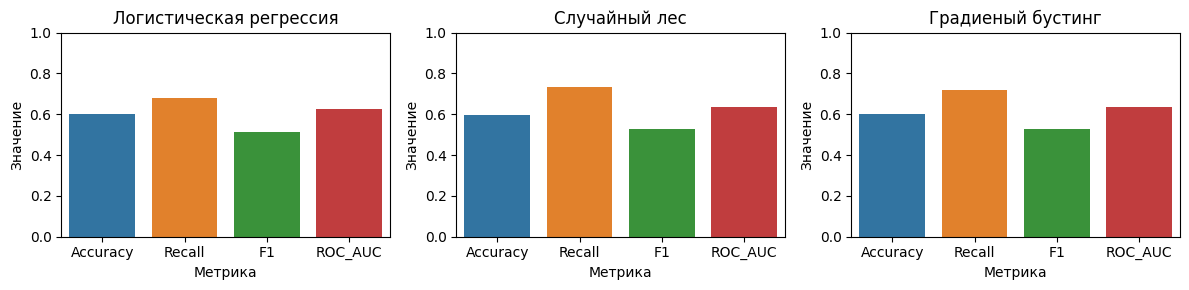

In [81]:
# графики для оценки на тренировочных данных
log_reg_pred = log_reg.predict(X_train)
random_forest_pred = random_forest.predict(X_train)
grad_boost_pred = grad_boost.predict(X_train)

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
titles = ['Логистическая регрессия', 'Случайный лес', 'Градиеный бустинг']

for i, prediction in enumerate([log_reg_pred, random_forest_pred, grad_boost_pred]):
    evaluate_predictions(y_train, prediction, ax=ax[i], title=titles[i])
    
plt.tight_layout()
plt.savefig("train_metrics.png", dpi=300, bbox_inches='tight')
plt.show()

In [82]:
log_reg_pred = log_reg.predict(X_train)
random_forest_pred = random_forest.predict(X_train)
grad_boost_pred = grad_boost.predict(X_train)

# Оценка метрик для каждой модели
evaluate_predictions_with_values(y_train, log_reg_pred, title='Логистическая регрессия')
evaluate_predictions_with_values(y_train, random_forest_pred, title='Случайный лес')
evaluate_predictions_with_values(y_train, grad_boost_pred, title='Градиентный бустинг')

Логистическая регрессия:
Accuracy: 0.6029
Recall: 0.6811
F1: 0.5142
ROC_AUC: 0.6246
----------------------------------------
Случайный лес:
Accuracy: 0.5973
Recall: 0.7312
F1: 0.5284
ROC_AUC: 0.6344
----------------------------------------
Градиентный бустинг:
Accuracy: 0.6019
Recall: 0.7174
F1: 0.5265
ROC_AUC: 0.6339
----------------------------------------


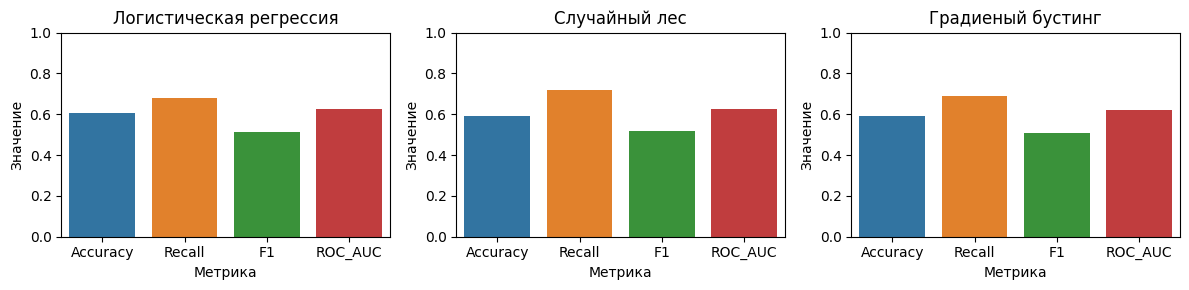

In [83]:
# графики для оценки на тестовых данных
log_reg_pred = log_reg.predict(X_test)
random_forest_pred = random_forest.predict(X_test)
grad_boost_pred = grad_boost.predict(X_test)

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
titles = ['Логистическая регрессия', 'Случайный лес', 'Градиеный бустинг']

for i, prediction in enumerate([log_reg_pred, random_forest_pred, grad_boost_pred]):
    evaluate_predictions(y_test, prediction, ax=ax[i], title=titles[i])
    
plt.tight_layout()
plt.savefig("test_metrics.png", dpi=300, bbox_inches='tight')
plt.show()

In [84]:
log_reg_pred = log_reg.predict(X_test)
random_forest_pred = random_forest.predict(X_test)
grad_boost_pred = grad_boost.predict(X_test)

# Оценка метрик для каждой модели
evaluate_predictions_with_values(y_test, log_reg_pred, title='Логистическая регрессия')
evaluate_predictions_with_values(y_test, random_forest_pred, title='Случайный лес')
evaluate_predictions_with_values(y_test, grad_boost_pred, title='Градиентный бустинг')

Логистическая регрессия:
Accuracy: 0.6048
Recall: 0.6771
F1: 0.5128
ROC_AUC: 0.6249
----------------------------------------
Случайный лес:
Accuracy: 0.5896
Recall: 0.7188
F1: 0.5183
ROC_AUC: 0.6255
----------------------------------------
Градиентный бустинг:
Accuracy: 0.5936
Recall: 0.6875
F1: 0.5097
ROC_AUC: 0.6197
----------------------------------------


                 Model  CV Accuracy
0  Logistic Regression     0.603200
1        Random Forest     0.592533
2    Gradient Boosting     0.593600
                 Model     CV F1
0  Logistic Regression  0.514516
1        Random Forest  0.515004
2    Gradient Boosting  0.509653
                 Model  CV Recall
0  Logistic Regression    0.68190
1        Random Forest    0.70178
2    Gradient Boosting    0.68750
                 Model  CV ROC_AUC
0  Logistic Regression    0.653760
1        Random Forest    0.652458
2    Gradient Boosting    0.648355


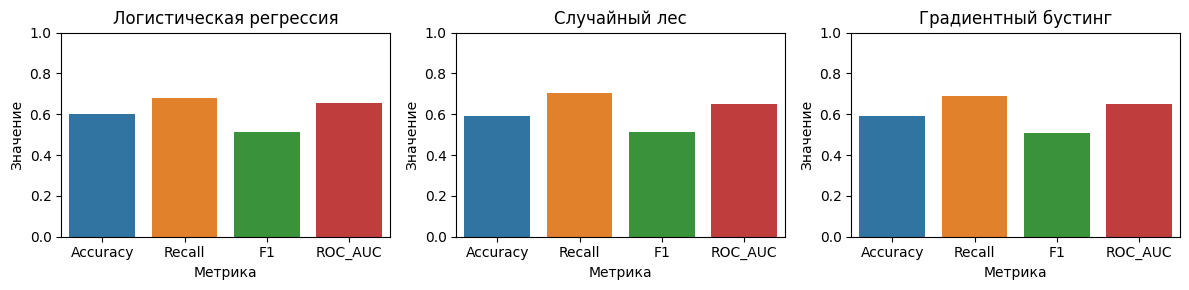

In [85]:
# Графики и статистика для оценки с помощью кросс-валидации
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
titles = ['Логистическая регрессия', 'Случайный лес', 'Градиентный бустинг']
accuracy_scores = []
f1_scores = []
recall_scores = []
roc_auc_scores = []

for i, model in enumerate([log_reg, random_forest, grad_boost]):
    scoring = ['accuracy', 'recall', 'f1', 'roc_auc']

    if model == grad_boost:
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        cv_scores_plot = pd.DataFrame({
            'Metric': ['Accuracy', 'Recall', 'F1', 'ROC_AUC'],
            'Score': [accuracy_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred), roc_auc_score(y_test, y_proba)]
        })

        accuracy_scores.append(accuracy_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        roc_auc_scores.append(roc_auc_score(y_test, y_proba))

        sns.barplot(data=cv_scores_plot, x='Metric', y='Score', ax=ax[i])
        ax[i].set_ylim(0, 1)
        ax[i].set_title(titles[i])
        ax[i].set_ylabel('Значение')
        ax[i].set_xlabel('Метрика')

    else:
        stats = cross_validate(model, X_train, y_train, scoring=scoring, cv=5, return_train_score=True)
        cv_scores_plot = pd.DataFrame({
            'Metric': ['Accuracy', 'Recall', 'F1', 'ROC_AUC'],
            'Score': [stats['test_accuracy'].mean(), stats['test_recall'].mean(), stats['test_f1'].mean(), stats['test_roc_auc'].mean()]
        })

        accuracy_scores.append(stats['test_accuracy'].mean())
        f1_scores.append(stats['test_f1'].mean())
        recall_scores.append(stats['test_recall'].mean())
        roc_auc_scores.append(stats['test_roc_auc'].mean())

        sns.barplot(data=cv_scores_plot, x='Metric', y='Score', ax=ax[i])
        ax[i].set_ylim(0, 1)
        ax[i].set_title(titles[i])
        ax[i].set_ylabel('Значение')
        ax[i].set_xlabel('Метрика')

cv_accuracy = pd.DataFrame(list(zip(['Logistic Regression', 'Random Forest', 'Gradient Boosting'], accuracy_scores)), columns=['Model', 'CV Accuracy'])
cv_f1 = pd.DataFrame(list(zip(['Logistic Regression', 'Random Forest', 'Gradient Boosting'], f1_scores)), columns=['Model', 'CV F1'])
cv_recall = pd.DataFrame(list(zip(['Logistic Regression', 'Random Forest', 'Gradient Boosting'], recall_scores)), columns=['Model', 'CV Recall'])
cv_roc_auc = pd.DataFrame(list(zip(['Logistic Regression', 'Random Forest', 'Gradient Boosting'], roc_auc_scores)), columns=['Model', 'CV ROC_AUC'])

print(cv_accuracy)
print(cv_f1)
print(cv_recall)
print(cv_roc_auc)

plt.tight_layout()
plt.savefig("cross_val_metrics.png", dpi=300, bbox_inches='tight')
plt.show()


**Интерпретация и выводы.** Сначала мы обучали классификаторы, забыв настроить модели под задачу дисбаланса классов. По `accuracy` получились почти те же результаты, по `ROC_AUC` немного ниже, а по `F1` и `Recall` сильно низкие. Это показало нам, что модели обращают внимание в основном на мажорный класс, пытаясь предсказывать его. Если анализировать данные результаты, то результаты и до тюнинга моделей получились лучше, чем для случайного классификатора, что уже неплохо. По результатам на кросс-валидации можно оценить стабильность моделей. В целом, сравнивая модели между собой по всем метрикам, выделить лучшую - непростая задача. Но есть ощущение, что градиентный бустинг по значениям метрик на кросс-валидации немного отстает, показывая чуть более плохую устойчивость, но разница все равно незначительная.

## Пункт 3.

### Тюнинг

In [11]:
# Логистическая регрессия
log_reg = LogisticRegression(C=0.5, solver='liblinear', penalty='l2', max_iter=200, class_weight='balanced', random_state=666)
log_reg.fit(X_train, y_train)

# Случайный лес
random_forest = RandomForestClassifier(n_estimators=100, max_depth=5, class_weight='balanced', random_state=666)
random_forest.fit(X_train, y_train)

# Градиентный бустинг
grad_boost = GradientBoostingClassifier(n_estimators=150, learning_rate=0.05, max_depth=3, random_state=666)
weights = np.where(y_train == 0, train_share_of_minor, train_share_of_major)
grad_boost.fit(X_train, y_train, sample_weight=weights)

GradientBoostingClassifier(learning_rate=0.05, n_estimators=150,
                           random_state=666)

In [12]:
# Логистическая регрессия
log_reg_params = {'C': [0.2, 0.3, 0.5, 0.7, 1, 10], 
                  'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'], 
                  'penalty': ['l1', 'l2', 'None', 'elasticnet'], 
                  'max_iter': [30, 50, 80, 100, 200], 
                  'random_state': [666], 
                  'class_weight': ['balanced']}
log_reg_clf = GridSearchCV(log_reg, log_reg_params, scoring='accuracy', cv=5)
start_log_reg_acc = time.time()
log_reg_clf.fit(X_train, y_train)
end_log_reg_acc = time.time()
time_log_reg_acc = end_log_reg_acc - start_log_reg_acc


# Случайный лес
random_forest_params = {'n_estimators': [30, 50, 100, 200], 
                        'max_depth': [3, 5, 7, 10], 
                        'random_state': [666], 
                        'class_weight': ['balanced']}
random_forest_clf = GridSearchCV(random_forest, random_forest_params, scoring='accuracy', cv=5)
start_rand_forest_acc = time.time()
random_forest_clf.fit(X_train, y_train)
end_rand_forest_acc = time.time()
time_rand_forest_acc = end_rand_forest_acc - start_rand_forest_acc


# Градиентный бустинг
grad_boost_params = {'n_estimators': [30, 50, 150, 250], 
                     'max_depth': [3, 5, 10],
                     'learning_rate': [0.01, 0.05, 0.1, 1, 2], 
                     'random_state': [666]}
weights = np.where(y_train == 0, train_share_of_minor, train_share_of_major)
grad_boost_clf = GridSearchCV(grad_boost, grad_boost_params, scoring='accuracy', cv=5)
start_grad_boost_acc = time.time()
grad_boost_clf.fit(X_train, y_train, sample_weight=weights)
end_grad_boost_acc = time.time()
time_grad_boost_acc = end_grad_boost_acc - start_grad_boost_acc

In [13]:
results_acc = []

# Логистическая регрессия
results_acc.append({
    'Метод': 'Logistic Regression',
    'Начальные гиперпараметры': {k: log_reg.get_params()[k] for k in ['C', 'max_iter', 'penalty', 'solver']},
    'Настроенные гиперпараметры': log_reg_clf.best_params_,
    'CV accuracy до настройки': round(cv_accuracy.set_index('Model').loc['Logistic Regression']['CV Accuracy'], 3),
    'Accuracy на тесте до настройки': accuracy_score(y_test, log_reg.predict(X_test)),
    'CV accuracy после настройки': round(log_reg_clf.best_score_, 3),
    'Accuracy на тесте после настройки': accuracy_score(y_test, log_reg_clf.best_estimator_.predict(X_test)),
    'Время тюнинга': round(time_log_reg_acc, 3)
})

# Случайный лес
results_acc.append({
    'Метод': 'Random Forest',
    'Начальные гиперпараметры': {k: random_forest.get_params()[k] for k in ['max_depth', 'n_estimators']},
    'Настроенные гиперпараметры': random_forest_clf.best_params_,
    'CV accuracy до настройки': round(cv_accuracy.set_index('Model').loc['Random Forest']['CV Accuracy'], 3),
    'Accuracy на тесте до настройки': accuracy_score(y_test, random_forest.predict(X_test)),
    'CV accuracy после настройки': round(random_forest_clf.best_score_, 3),
    'Accuracy на тесте после настройки': accuracy_score(y_test, random_forest_clf.best_estimator_.predict(X_test)),
    'Время тюнинга': round(time_rand_forest_acc, 3)
})


# Градиентный бустинг
results_acc.append({
    'Метод': 'Gradient Boosting',
    'Начальные гиперпараметры': {k: grad_boost.get_params()[k] for k in ['learning_rate', 'max_depth', 'n_estimators']},
    'Настроенные гиперпараметры': grad_boost_clf.best_params_,
    'CV accuracy до настройки': round(cv_accuracy.set_index('Model').loc['Gradient Boosting']['CV Accuracy'], 3),
    'Accuracy на тесте до настройки': accuracy_score(y_test, grad_boost.predict(X_test)),
    'CV accuracy после настройки': round(grad_boost_clf.best_score_, 3),
    'Accuracy на тесте после настройки': accuracy_score(y_test, grad_boost_clf.best_estimator_.predict(X_test)),
    'Время тюнинга': round(time_grad_boost_acc, 3)
})

In [14]:
pd.set_option('display.max_colwidth', None)
results_acc = pd.DataFrame(results_acc)
results_acc

,Метод,Начальные гиперпараметры,Настроенные гиперпараметры,CV accuracy до настройки,Accuracy на тесте до настройки,CV accuracy после настройки,Accuracy на тесте после настройки,Время тюнинга
0,Logistic Regression,"{'C': 0.5, 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}","{'C': 0.7, 'class_weight': 'balanced', 'max_iter': 30, 'penalty': 'l1', 'random_state': 666, 'solver': 'saga'}",0.587,0.5808,0.590,0.5728,15.468
1,Random Forest,"{'max_depth': 5, 'n_estimators': 100}","{'class_weight': 'balanced', 'max_depth': 7, 'n_estimators': 100, 'random_state': 666}",0.600,0.5904,0.595,0.5744,6.591
2,Gradient Boosting,"{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 150}","{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 250, 'random_state': 666}",0.587,0.5872,0.589,0.5896,84.555


**OOB для Random Forest**

In [15]:
def tune_rf_by_oob(X_train, y_train, X_test, y_test, param_grid):
    results = []
    
    keys, values = zip(*param_grid.items())
    for param_values in product(*values):
        params = dict(zip(keys, param_values))

        model = RandomForestClassifier(
            **params,
            oob_score=True,
            bootstrap=True,
            random_state=666,
            n_jobs=-1,
            class_weight='balanced'
        )
        model.fit(X_train, y_train)
        oob_score = model.oob_score_
        test_acc = accuracy_score(y_test, model.predict(X_test))

        results.append({
            'Параметры': params,
            'OOB accuracy': round(oob_score, 4),
            'Test accuracy': round(test_acc, 4)
        })

    results_df = pd.DataFrame(results)
    best_row = results_df.loc[results_df['OOB accuracy'].idxmax()]

    print("Лучшие параметры по OOB:")
    print(best_row['Параметры'])
    print(f"\nАccuracy при OOB: {best_row['Test accuracy']}")

    return results_df, best_row


In [16]:
param_grid_rf = {'n_estimators': [30, 50, 100, 200], 'max_depth': [3, 5, 7, 10]}
results_df, best_result = tune_rf_by_oob(X_train, y_train, X_test, y_test, param_grid_rf)

Лучшие параметры по OOB:
{'n_estimators': 200, 'max_depth': 7}

Аccuracy при OOB: 0.5776


In [17]:
print("Гиперпараметры при CV: ", results_acc.loc[results_acc['Метод'] == 'Random Forest', 'Настроенные гиперпараметры'][1])
print("Accuracy при CV: ", results_acc.loc[results_acc['Метод'] == 'Random Forest', 'Accuracy на тесте после настройки'][1])

Гиперпараметры при CV:  {'class_weight': 'balanced', 'max_depth': 7, 'n_estimators': 100, 'random_state': 666}
Accuracy при CV:  0.5744


## Пункт 4.

### Тюнинг

In [86]:
# Логистическая регрессия
log_reg_params = {'C': [0.2, 0.3, 0.5, 0.7, 1, 10], 
                  'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'], 
                  'penalty': ['l1', 'l2', 'None', 'elasticnet'], 
                  'max_iter': [30, 50, 80, 100, 200], 
                  'random_state': [666], 
                  'class_weight': ['balanced']}
log_reg_clf_f1 = GridSearchCV(log_reg, log_reg_params, scoring='f1', cv=5)
start_log_reg_f1 = time.time()
log_reg_clf_f1.fit(X_train, y_train)
end_log_reg_f1 = time.time()
time_log_reg_f1 = end_log_reg_f1 - start_log_reg_f1


# Случайный лес
random_forest_params = {'n_estimators': [30, 50, 100, 200], 
                        'max_depth': [3, 5, 7, 10], 
                        'random_state': [666], 
                        'class_weight': ['balanced']}
random_forest_clf_f1 = GridSearchCV(random_forest, random_forest_params, scoring='f1', cv=5)
start_rand_forest_f1 = time.time()
random_forest_clf_f1.fit(X_train, y_train)
end_rand_forest_f1 = time.time()
time_rand_forest_f1 = end_rand_forest_f1 - start_rand_forest_f1


# Градиентный бустинг
grad_boost_params = {'n_estimators': [30, 50, 150, 250], 
                     'max_depth': [3, 5, 10],
                     'learning_rate': [0.01, 0.05, 0.1, 1, 2], 
                     'random_state': [666]}
weights = np.where(y_train == 0, train_share_of_minor, train_share_of_major)
grad_boost_clf_f1 = GridSearchCV(grad_boost, grad_boost_params, scoring='f1', cv=5)
start_grad_boost_f1 = time.time()
grad_boost_clf_f1.fit(X_train, y_train, sample_weight=weights)
end_grad_boost_f1 = time.time()
time_grad_boost_f1 = end_grad_boost_f1 - start_grad_boost_f1

In [87]:
results_f1 = []

# Логистическая регрессия
results_f1.append({
    'Метод': 'Logistic Regression',
    'Начальные гиперпараметры': {k: log_reg.get_params()[k] for k in ['C', 'max_iter', 'penalty', 'solver']},
    'Настроенные гиперпараметры': log_reg_clf_f1.best_params_,
    'CV F1 до настройки': round(cv_f1.set_index('Model').loc['Logistic Regression']['CV F1'], 3),
    'F1 на тесте до настройки': f1_score(y_test, log_reg.predict(X_test)),
    'CV F1 после настройки': round(log_reg_clf_f1.best_score_, 3),
    'F1 на тесте после настройки': f1_score(y_test, log_reg_clf_f1.best_estimator_.predict(X_test)),
    'Время тюнинга': round(time_log_reg_f1, 3)
})

# Случайный лес
results_f1.append({
    'Метод': 'Random Forest',
    'Начальные гиперпараметры': {k: random_forest.get_params()[k] for k in ['max_depth', 'n_estimators']},
    'Настроенные гиперпараметры': random_forest_clf_f1.best_params_,
    'CV F1 до настройки': round(cv_f1.set_index('Model').loc['Random Forest']['CV F1'], 3),
    'F1 на тесте до настройки': f1_score(y_test, random_forest.predict(X_test)),
    'CV F1 после настройки': round(random_forest_clf_f1.best_score_, 3),
    'F1 на тесте после настройки': f1_score(y_test, random_forest_clf_f1.best_estimator_.predict(X_test)),
    'Время тюнинга': round(time_rand_forest_f1, 3)
})


# Градиентный бустинг
results_f1.append({
    'Метод': 'Gradient Boosting',
    'Начальные гиперпараметры': {k: grad_boost.get_params()[k] for k in ['learning_rate', 'max_depth', 'n_estimators']},
    'Настроенные гиперпараметры': grad_boost_clf_f1.best_params_,
    'CV F1 до настройки': round(cv_f1.set_index('Model').loc['Gradient Boosting']['CV F1'], 3),
    'F1 на тесте до настройки': f1_score(y_test, grad_boost.predict(X_test)),
    'CV F1 после настройки': round(grad_boost_clf_f1.best_score_, 3),
    'F1 на тесте после настройки': f1_score(y_test, grad_boost_clf_f1.best_estimator_.predict(X_test)),
    'Время тюнинга': round(time_grad_boost_f1, 3)
})

In [88]:
pd.set_option('display.max_colwidth', None)
results_f1 = pd.DataFrame(results_f1)
results_f1

,Метод,Начальные гиперпараметры,Настроенные гиперпараметры,CV F1 до настройки,F1 на тесте до настройки,CV F1 после настройки,F1 на тесте после настройки,Время тюнинга
0,Logistic Regression,"{'C': 0.5, 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}","{'C': 0.3, 'class_weight': 'balanced', 'max_iter': 30, 'penalty': 'l2', 'random_state': 666, 'solver': 'lbfgs'}",0.515,0.512821,0.515,0.514286,22.936
1,Random Forest,"{'max_depth': 5, 'n_estimators': 100}","{'class_weight': 'balanced', 'max_depth': 5, 'n_estimators': 200, 'random_state': 666}",0.515,0.518310,0.515,0.517670,11.079
2,Gradient Boosting,"{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 150}","{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50, 'random_state': 666}",0.510,0.509653,0.514,0.509921,137.707


**Новая метрика:**
В качестве новой метрики мы решили взять cost-matrix для бинарной классификации. Вдохновились [статьей](https://proceedings.mlr.press/v39/lin14.pdf), где авторы говорят, что зачастую цена ошибки отличается в зависимости от вида неправильной классификации. Например, сказать, что у человека "простуда", когда он заражен холерой куда неприятнее (в плане последствий ошибки), чем сделать предположение, что человек болен холерой, если на самом деле у него простуда и ничего серьезного его жизни не грозит. <br>
Также несложно оправдать эту метрику в задачах об одобрении кредита: куда дороже для банка довериться ненадежному клиенту, чем отказать надежному. 
<br>
Если переложить это на наш случай, то преимущества/недостатки этой метрики зависит от цели, для которой мы хотим предсказать наличие или отсутствие высшего образования у человека:
* Если мы крайне известная IT-компания с высоким порогом входа и почему-то мы не знаем ничего про образование человека, то цена предположения о наличии высшего у человека при его отсутствии в реальности выше, чем обратная неправильная классификация ==> **в этом случае метрика полезна!**
* Если мы просто предсказываем статистику по городу/области (для обычного социального исследования), то нам не важно, каким конкретно образом ошиблась модель и тогда **критерий с весами может быть не очень полезен**.

In [21]:
def cost_sensitive_loss(y_true, y_pred, cost_matrix):
    loss = 0
    cm = cost_matrix
    for i, j in zip(y_true, y_pred):
        loss += cm[i][j]
        
    return loss / len(y_true)

cost_matrix = [[0, 2], [1, 0]]
scorer = make_scorer(cost_sensitive_loss, greater_is_better=False, cost_matrix=cost_matrix)

In [22]:
# демонстративный пример
cost_matrix = [[0, 2], [1, 0]]
y_pred_ = log_reg.predict(X_test)

cost_sensitive_loss(y_test, y_pred_, cost_matrix)

0.7232

### Тюнинг

In [89]:
# Логистическая регрессия
log_reg_params = {'C': [0.2, 0.3, 0.5, 0.7, 1, 10], 
                  'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'], 
                  'penalty': ['l1', 'l2', 'None', 'elasticnet'], 
                  'max_iter': [30, 50, 80, 100, 200], 
                  'random_state': [666], 
                  'class_weight': ['balanced']}
log_reg_clf_custom = GridSearchCV(log_reg, log_reg_params, scoring=scorer, cv=5)
start_log_reg = time.time()
log_reg_clf_custom.fit(X_train, y_train)
end_log_reg = time.time()
time_log_reg = end_log_reg - start_log_reg


# Случайный лес
random_forest_params = {'n_estimators': [30, 50, 100, 200], 
                        'max_depth': [3, 5, 7, 10], 
                        'random_state': [666], 
                        'class_weight': ['balanced']}
random_forest_clf_custom = GridSearchCV(random_forest, random_forest_params, scoring=scorer, cv=5)
start_rand_forest = time.time()
random_forest_clf_custom.fit(X_train, y_train)
end_rand_forest = time.time()
time_rand_forest = end_rand_forest - start_rand_forest


# Градиентный бустинг
grad_boost_params = {'n_estimators': [30, 50, 150, 250], 
                     'max_depth': [3, 5, 10],
                     'learning_rate': [0.01, 0.05, 0.1, 1, 2], 
                     'random_state': [666]}
weights = np.where(y_train == 0, train_share_of_minor, train_share_of_major)
grad_boost_clf_custom = GridSearchCV(grad_boost, grad_boost_params, scoring=scorer, cv=5)
start_grad_boost = time.time()
grad_boost_clf_custom.fit(X_train, y_train, sample_weight=weights)
end_grad_boost = time.time()
time_grad_boost = end_grad_boost - start_grad_boost

Повторите предыдущий пункт, используя любой альтернативный критерий ка-
чества модели. Обоснуйте возможные преимущества и недостатки этого аль-
тернативного критерия. <br>
<br>
**Повышенная сложность:** дополнительно самостоятельно запрограммируйте
не представленный в стандартных библиотеках критерий качества и используйте его для тюнинга гиперпараметров. Сравните результат стандартного и
вашего критериев, а также опишите его преимущества и недостатки: в каких
случаях его разумно применять, а в каких случаях он может оказаться не очень
полезен.

In [90]:
def get_cost_loss(model, X, y, cost_matrix):
    y_pred = model.predict(X)
    return cost_sensitive_loss(y, y_pred, cost_matrix)

In [91]:
results = []

# Логистическая регрессия
acc_log_reg_params = results_acc.set_index('Метод').loc['Logistic Regression', 'Настроенные гиперпараметры']
acc_log_reg_cv = results_acc.set_index('Метод').loc['Logistic Regression', 'CV accuracy после настройки']
acc_log_reg_test_acc = results_acc.set_index('Метод').loc['Logistic Regression', 'Accuracy на тесте после настройки']

log_reg_cost_test_acc = accuracy_score(y_test, log_reg_clf_custom.predict(X_test))
log_reg_cost_test_loss = get_cost_loss(log_reg_clf_custom, X_test, y_test, cost_matrix)

results.append({
    'Метод': 'Logistic Regression',
    'Параметры (accuracy)': acc_log_reg_params,
    'Параметры (cost)': log_reg_clf_custom.best_params_,
    'CV accuracy (после подбора по accuracy)': round(acc_log_reg_cv, 3),
    'CV accuracy (после подбора по cost)': round(log_reg_cost_test_acc, 3),
    'Test accuracy (accuracy-подбор)': round(acc_log_reg_test_acc, 3),
    'Test accuracy (cost-подбор)': round(log_reg_cost_test_acc, 3),
    'Test cost-sensitive loss': round(log_reg_cost_test_loss, 3),
    'Время тюнинга': round(time_log_reg, 3)
})


# Случайный лес
acc_rand_forest_params = results_acc.set_index('Метод').loc['Random Forest', 'Настроенные гиперпараметры']
acc_rand_forest_cv = results_acc.set_index('Метод').loc['Random Forest', 'CV accuracy после настройки']
acc_rand_forest_test_acc = results_acc.set_index('Метод').loc['Random Forest', 'Accuracy на тесте после настройки']

rand_forest_cost_test_acc = accuracy_score(y_test, random_forest_clf_custom.predict(X_test))
rand_forest_cost_test_loss = get_cost_loss(random_forest_clf_custom, X_test, y_test, cost_matrix)

results.append({
    'Метод': 'Random Forest',
    'Параметры (accuracy)': acc_rand_forest_params,
    'Параметры (cost)': random_forest_clf_custom.best_params_,
    'CV accuracy (после подбора по accuracy)': round(acc_rand_forest_cv, 3),
    'CV accuracy (после подбора по cost)': round(rand_forest_cost_test_acc, 3),
    'Test accuracy (accuracy-подбор)': round(acc_rand_forest_test_acc, 3),
    'Test accuracy (cost-подбор)': round(rand_forest_cost_test_acc, 3),
    'Test cost-sensitive loss': round(rand_forest_cost_test_loss, 3),
    'Время тюнинга': round(time_rand_forest, 3)
})


# Градиентный бустинг
acc_grad_boost_params = results_acc.set_index('Метод').loc['Gradient Boosting', 'Настроенные гиперпараметры']
acc_grad_boost_cv = results_acc.set_index('Метод').loc['Gradient Boosting', 'CV accuracy после настройки']
acc_grad_boost_test_acc = results_acc.set_index('Метод').loc['Gradient Boosting', 'Accuracy на тесте после настройки']

grad_boost_cost_test_acc = accuracy_score(y_test, grad_boost_clf_custom.predict(X_test))
grad_boost_cost_test_loss = get_cost_loss(grad_boost_clf_custom, X_test, y_test, cost_matrix)

results.append({
    'Метод': 'Gradient Boosting',
    'Параметры (accuracy)': acc_grad_boost_params,
    'Параметры (cost)': grad_boost_clf_custom.best_params_,
    'CV accuracy (после подбора по accuracy)': round(acc_grad_boost_cv, 3),
    'CV accuracy (после подбора по cost)': round(grad_boost_cost_test_acc, 3),
    'Test accuracy (accuracy-подбор)': round(acc_grad_boost_test_acc, 3),
    'Test accuracy (cost-подбор)': round(grad_boost_cost_test_acc, 3),
    'Test cost-sensitive loss': round(grad_boost_cost_test_loss, 3),
    'Время тюнинга': round(time_grad_boost, 3)
})

In [92]:
pd.set_option('display.max_colwidth', None)
results = pd.DataFrame(results)
results

,Метод,Параметры (accuracy),Параметры (cost),CV accuracy (после подбора по accuracy),CV accuracy (после подбора по cost),Test accuracy (accuracy-подбор),Test accuracy (cost-подбор),Test cost-sensitive loss,Время тюнинга
0,Logistic Regression,"{'C': 0.7, 'class_weight': 'balanced', 'max_iter': 30, 'penalty': 'l1', 'random_state': 666, 'solver': 'saga'}","{'C': 0.7, 'class_weight': 'balanced', 'max_iter': 30, 'penalty': 'l2', 'random_state': 666, 'solver': 'saga'}",0.590,0.608,0.573,0.608,0.685,16.219
1,Random Forest,"{'class_weight': 'balanced', 'max_depth': 7, 'n_estimators': 100, 'random_state': 666}","{'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 200, 'random_state': 666}",0.595,0.595,0.574,0.595,0.674,6.810
2,Gradient Boosting,"{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 250, 'random_state': 666}","{'learning_rate': 1, 'max_depth': 3, 'n_estimators': 150, 'random_state': 666}",0.589,0.608,0.590,0.608,0.660,84.727


## Пункт 5.

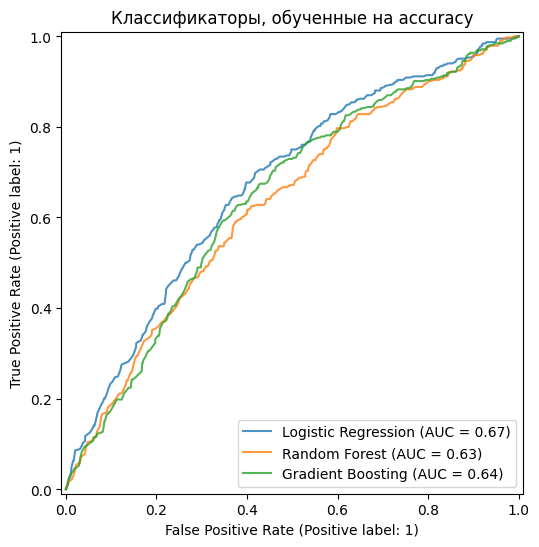

In [95]:
fig, ax = plt.subplots(figsize=(8, 6))

rfc_disp = RocCurveDisplay.from_estimator(log_reg_clf, X_test, y_test, ax=ax, alpha=0.8, name="Logistic Regression")
rfc_disp = RocCurveDisplay.from_estimator(random_forest_clf, X_test, y_test, ax=ax, alpha=0.8, name="Random Forest")
rfc_disp = RocCurveDisplay.from_estimator(grad_boost_clf, X_test, y_test, ax=ax, alpha=0.8, name="Gradient Boosting")

plt.title('Классификаторы, обученные на accuracy')
plt.savefig("roc_auc_acc.png", dpi=300, bbox_inches='tight')
plt.show()

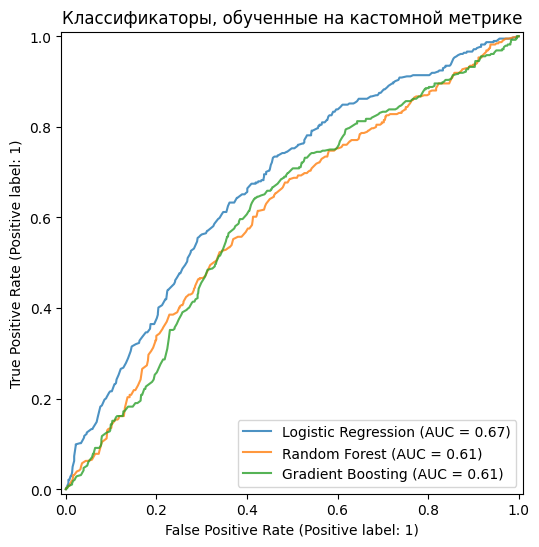

In [96]:
fig, ax = plt.subplots(figsize=(8, 6))

rfc_disp = RocCurveDisplay.from_estimator(log_reg_clf_custom, X_test, y_test, ax=ax, alpha=0.8, name="Logistic Regression")
rfc_disp = RocCurveDisplay.from_estimator(random_forest_clf_custom, X_test, y_test, ax=ax, alpha=0.8, name="Random Forest")
rfc_disp = RocCurveDisplay.from_estimator(grad_boost_clf_custom, X_test, y_test, ax=ax, alpha=0.8, name="Gradient Boosting")

plt.title('Классификаторы, обученные на кастомной метрике')
plt.savefig("roc_auc_custom.png", dpi=300, bbox_inches='tight')
plt.show()

In [29]:
# !pip install bnlearn

In [98]:
df_train = pd.DataFrame(X_train, columns=['far_from_uni', 'adhd', 'low_focus', 'age', 'reads_often'])
df_train['target'] = y_train

df_test = pd.DataFrame(X_test, columns=['far_from_uni', 'adhd', 'low_focus', 'age', 'reads_often'])
df_test['target'] = y_test

# Выполним дискретизацию 'age' на обучающей выборке
_, age_bins = pd.qcut(df_train['age'], q=3, duplicates='drop', retbins=True)
labels = ['young', 'middle', 'old'][:len(age_bins) - 1]

df_train_disc = df_train.copy()
df_train_disc['age'] = pd.cut(df_train['age'], bins=age_bins, labels=labels, include_lowest=True)
df_train_disc = df_train_disc.astype(str)

df_test_disc = df_test.copy()
df_test_disc['age'] = pd.cut(df_test['age'], bins=age_bins, labels=labels, include_lowest=True)
df_test_disc = df_test_disc.astype(str)

learned_bn_model = bn.structure_learning.fit(df_train_disc)
learned_bn_model = bn.parameter_learning.fit(learned_bn_model, df_train_disc)

y_probs = []
for _, row in df_test_disc.iterrows():
    evidence = row.drop('target').to_dict()
    try:
        q = bn.inference.fit(learned_bn_model, variables=['target'], evidence=evidence)
        states = q.state_names['target']
        values = q.values
        if '1' in states:
            prob_1 = values[states.index('1')]
        else:
            prob_1 = 0.5
        y_probs.append(prob_1)
    except Exception as e:
        y_probs.append(0.5)

y_true = df_test['target'].astype(str)
auc_score = roc_auc_score(y_true == '1', y_probs)

print(f"AUC Байесовской сети на тесте: {round(auc_score, 3)}")


[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.


/Users/andrewnizov/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/andrewnizov/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/andrewnizov/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/andrewnizov/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/andrewnizov/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:6

[bnlearn] >CPD of adhd:
+-----------+---------------------+--------------------+
| low_focus | low_focus(0)        | low_focus(1)       |
+-----------+---------------------+--------------------+
| adhd(0)   | 0.9075785582255084  | 0.5941320293398533 |
+-----------+---------------------+--------------------+
| adhd(1)   | 0.09242144177449169 | 0.4058679706601467 |
+-----------+---------------------+--------------------+
[bnlearn] >CPD of target:
+-----------+--------------------+--------------------+
| adhd      | adhd(0)            | adhd(1)            |
+-----------+--------------------+--------------------+
| target(0) | 0.6425068119891009 | 0.6805555555555556 |
+-----------+--------------------+--------------------+
| target(1) | 0.3574931880108992 | 0.3194444444444444 |
+-----------+--------------------+--------------------+
[bnlearn] >CPD of low_focus:
+--------------+----------+
| low_focus(0) | 0.569474 |
+--------------+----------+
| low_focus(1) | 0.430526 |
+--------------+--

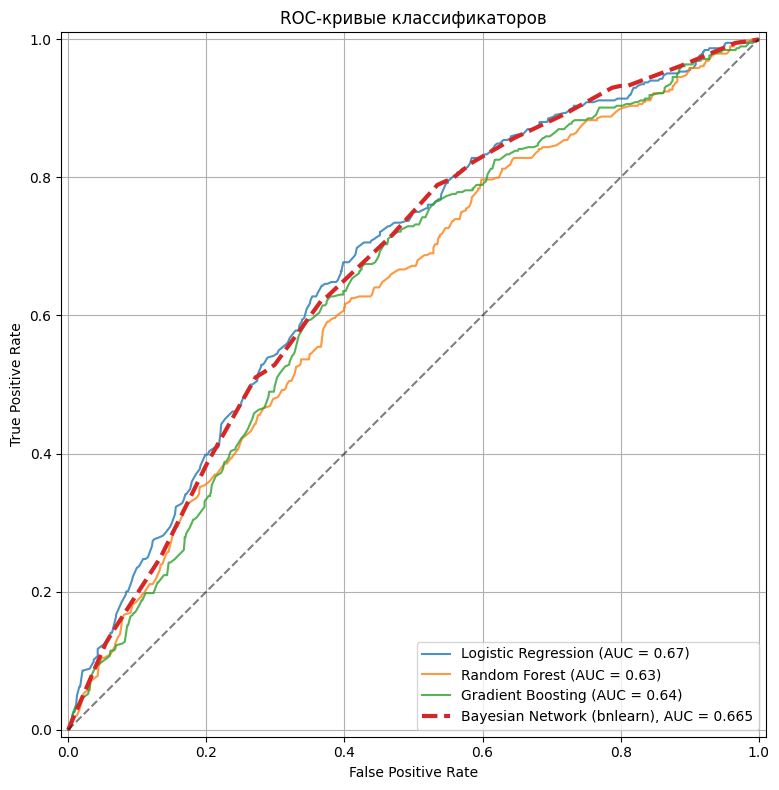

In [99]:
fig, ax = plt.subplots(figsize=(10, 8))

RocCurveDisplay.from_estimator(log_reg_clf, X_test, y_test, ax=ax, alpha=0.8, name="Logistic Regression")
RocCurveDisplay.from_estimator(random_forest_clf, X_test, y_test, ax=ax, alpha=0.8, name="Random Forest")
RocCurveDisplay.from_estimator(grad_boost_clf, X_test, y_test, ax=ax, alpha=0.8, name="Gradient Boosting")

fpr_bn, tpr_bn, _ = roc_curve(y_test, y_probs)
roc_auc_bn = auc(fpr_bn, tpr_bn)
ax.plot(fpr_bn, tpr_bn, label=f"Bayesian Network (bnlearn), AUC = {roc_auc_bn:.3f}", linestyle='--', linewidth=3)


ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC-кривые классификаторов")
ax.legend(loc="lower right")
ax.grid(True)
plt.tight_layout()
plt.savefig("roc_auc_bayes.png", dpi=300, bbox_inches='tight')
plt.show()


## Пункт 6.

In [32]:
def compute_profit(y_true, y_scores, threshold, cost_matrix):
    y_pred = (y_scores >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    TN, FP, FN, TP = cm.ravel()
    
    return (TN*cost_matrix[0][0] + FP*cost_matrix[0][1] + FN*cost_matrix[1][0] + TP*cost_matrix[1][1])

**Предположим**, что при прогнозировании наличия высшего образования у человека теряется 80 у.е., если модель говорит "есть образование", но его нет, так как это напрасная вера в квалификацию → рискованный найм; 30 у.е. теряется, если модель говорит "нет образования", но оно есть, так как недополучен ценный сотрудник. Если верно определен человек с высшим образованием, то это приносит 100 у.е., верно отсеянный кандидат без образования - ничего не меняет.

In [33]:
models = {
    "Logistic Regression": log_reg_clf,
    "Random Forest": random_forest_clf,
    "Gradient Boosting": grad_boost_clf
}

profit_matrix = [[0, -80], 
                 [-30, 100]]
results_profit_linear = []

for name, model in models.items():
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_test_proba = model.predict_proba(X_test)[:, 1]

    thresholds = np.linspace(0, 1, 101)
    profits = [compute_profit(y_train, y_train_proba, t, profit_matrix) for t in thresholds]

    best_threshold = thresholds[np.argmax(profits)]
    test_profit = compute_profit(y_test, y_test_proba, best_threshold, profit_matrix)
    test_auc = roc_auc_score(y_test, y_test_proba)

    results_profit_linear.append({
        'Модель': name,
        'AUC на тесте': round(test_auc, 3),
        'Оптимальный порог': round(best_threshold, 2),
        'Прибыль на тесте': int(test_profit)
    })

In [34]:
results_profit_linear = pd.DataFrame(results_profit_linear)
results_profit_linear

,Модель,AUC на тесте,Оптимальный порог,Прибыль на тесте
0,Logistic Regression,0.624,0.57,-7760
1,Random Forest,0.607,0.53,-11960
2,Gradient Boosting,0.618,0.57,-10160


In [35]:
def custom_profit_nonlinear(y_true, y_scores, threshold, cost_matrix):
    y_pred = (y_scores >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    TN, FP, FN, TP = cm.ravel()

    return TN*cost_matrix[0][0] + FP*cost_matrix[0][1] + FN*cost_matrix[1][0] + np.log1p(TP)*cost_matrix[1][1]

**Обоснование:** вместо простой линейной зависимости прибыли от `TP` (то есть ситуации, когда модель правильно определила человека с высшим), мы применяем логарифмическую функцию (`np.log1p(TP)`), отражающую **уменьшающийся эффект отдачи**: каждый следующий правильно найденный образованный кандидат полезен, но немного менее важен, чем предыдущий (некий принцип предельной полезности).

In [36]:
models = {
    "Logistic Regression": log_reg_clf,
    "Random Forest": random_forest_clf,
    "Gradient Boosting": grad_boost_clf
}

results_profit_unlinear = []

for name, model in models.items():
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_test_proba = model.predict_proba(X_test)[:, 1]

    thresholds = np.linspace(0, 1, 101)
    profits = [custom_profit_nonlinear(y_train, y_train_proba, t, profit_matrix) for t in thresholds]

    best_threshold = thresholds[np.argmax(profits)]
    test_profit = custom_profit_nonlinear(y_test, y_test_proba, best_threshold, profit_matrix)
    test_auc = roc_auc_score(y_test, y_test_proba)

    results_profit_unlinear.append({
        'Модель': name,
        'AUC на тесте': round(test_auc, 3),
        'Оптимальный порог': round(best_threshold, 2),
        'Прибыль на тесте': int(test_profit)
    })

In [37]:
results_profit_unlinear = pd.DataFrame(results_profit_unlinear)
results_profit_unlinear

,Модель,AUC на тесте,Оптимальный порог,Прибыль на тесте
0,Logistic Regression,0.624,0.72,-11700
1,Random Forest,0.607,0.76,-12410
2,Gradient Boosting,0.618,0.74,-11760


## Пункт 7.

In [103]:
bins = [15, 25, 40, 60]
labels = ['young', 'middle', 'old']

df_train = pd.DataFrame(X_train, columns=['far_from_uni', 'adhd', 'low_focus', 'age', 'reads_often'])
df_train['target'] = y_train

df_test = pd.DataFrame(X_test, columns=['far_from_uni', 'adhd', 'low_focus', 'age', 'reads_often'])
df_test['target'] = y_test

df_train['age'] = pd.cut(df_train['age'], bins=bins, labels=labels, include_lowest=True)
df_test['age'] = pd.cut(df_test['age'], bins=bins, labels=labels, include_lowest=True)

df_train_disc = df_train.astype(str)
df_test_disc = df_test.astype(str)

In [104]:
learned_model = bn.structure_learning.fit(df_train_disc)
learned_model = bn.parameter_learning.fit(learned_model, df_train_disc)

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.


/Users/andrewnizov/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/andrewnizov/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


[bnlearn] >CPD of adhd:
+-----------+---------------------+--------------------+
| low_focus | low_focus(0)        | low_focus(1)       |
+-----------+---------------------+--------------------+
| adhd(0)   | 0.9075785582255084  | 0.5941320293398533 |
+-----------+---------------------+--------------------+
| adhd(1)   | 0.09242144177449169 | 0.4058679706601467 |
+-----------+---------------------+--------------------+
[bnlearn] >CPD of target:
+-----------+--------------------+--------------------+
| adhd      | adhd(0)            | adhd(1)            |
+-----------+--------------------+--------------------+
| target(0) | 0.6425068119891009 | 0.6805555555555556 |
+-----------+--------------------+--------------------+
| target(1) | 0.3574931880108992 | 0.3194444444444444 |
+-----------+--------------------+--------------------+
[bnlearn] >CPD of low_focus:
+--------------+----------+
| low_focus(0) | 0.569474 |
+--------------+----------+
| low_focus(1) | 0.430526 |
+--------------+--

In [105]:
# предположим сами зависимости в данных
edges = [('far_from_uni', 'target'),
         ('age', 'target'),
         ('reads_often', 'target'),
         ('adhd', 'target'),
         ('low_focus', 'target'),
         ('adhd', 'low_focus'),
         ('age', 'reads_often')
        ]
DAG_manual = bn.make_DAG(edges, methodtype='bayes')
DAG_manual = bn.parameter_learning.fit(DAG_manual, df_train_disc, methodtype='bayes')

[bnlearn]> Auto generate placeholders for the CPTs.
[bnlearn] >CPT for target:
+--------------+-----------------+-----+-----------------+
| far_from_uni | far_from_uni(0) | ... | far_from_uni(1) |
+--------------+-----------------+-----+-----------------+
| age          | age(0)          | ... | age(1)          |
+--------------+-----------------+-----+-----------------+
| reads_often  | reads_often(0)  | ... | reads_often(1)  |
+--------------+-----------------+-----+-----------------+
| adhd         | adhd(0)         | ... | adhd(1)         |
+--------------+-----------------+-----+-----------------+
| low_focus    | low_focus(0)    | ... | low_focus(1)    |
+--------------+-----------------+-----+-----------------+
| target(0)    | 0.5             | ... | 0.5             |
+--------------+-----------------+-----+-----------------+
| target(1)    | 0.5             | ... | 0.5             |
+--------------+-----------------+-----+-----------------+
[bnlearn] >CPT for low_focus:
+-----

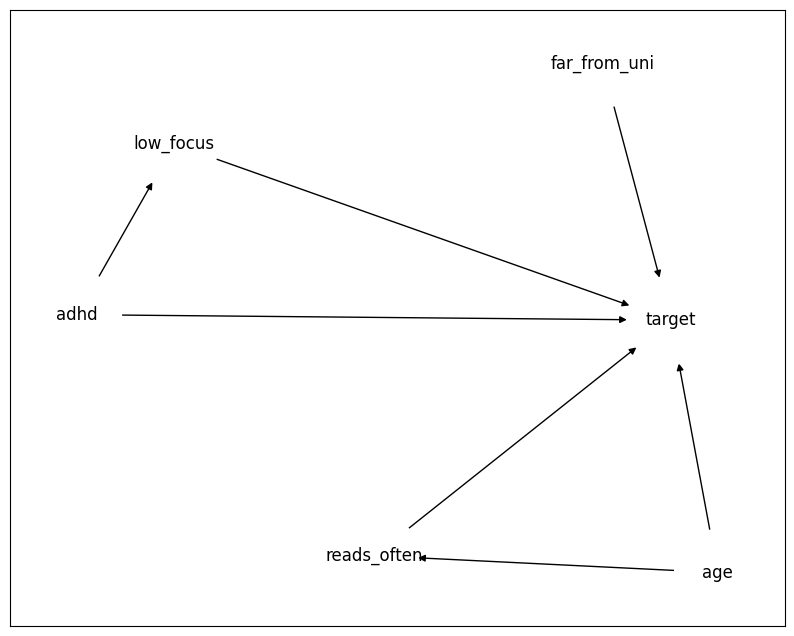

In [118]:
nx_options = {
    'node_color': 'white',
    'node_size': 4000,
    'width': 1,
    'arrowstyle': '-|>',
    'arrowsize': 10,
}

edges = [('far_from_uni', 'target'),
         ('age', 'target'),
         ('reads_often', 'target'),
         ('adhd', 'target'),
         ('low_focus', 'target'),
         ('adhd', 'low_focus'),
         ('age', 'reads_often')
        ]

G = nx.DiGraph(directed = True)
G.add_edges_from(edges)

plt.figure(figsize=(10, 8))
np.random.seed(666)
nx.draw_networkx(G, arrows = True, **nx_options)
plt.savefig("bayes_net.png", format="PNG")
plt.show()

In [148]:
def get_accuracy(bn_model, df_test):
    y_pred = []
    for _, row in df_test.iterrows():
        evidence = row.drop('target').to_dict()
        try:
            q = bn.inference.fit(bn_model, variables=['target'], evidence=evidence)
            states = q.state_names['target']
            values = q.values
            probs_dict = dict(zip(states, values))
            print(f"Probs for row: {probs_dict}")
            pred = max(probs_dict, key=probs_dict.get)
        except:
            pred = '0'
        y_pred.append(pred)

    return (df_test['target'].values == y_pred).mean()

In [149]:
acc_manual = get_accuracy(DAG_manual, df_test_disc)
acc_learned = get_accuracy(learned_bn_model, df_test_disc)

[bnlearn] >Variable Elimination.
+----+----------+----------+
|    |   target |        p |
+====+==========+==========+
|  0 |        0 | 0.771544 |
+----+----------+----------+
|  1 |        1 | 0.228456 |
+----+----------+----------+

Summary for variables: ['target']
Given evidence: far_from_uni=1, adhd=0, low_focus=0, age=middle, reads_often=0

target outcomes:
- target: 0 (77.2%)
- target: 1 (22.8%)
Probs for row: {'0': 0.7715437073775574, '1': 0.22845629262244266}
[bnlearn] >Variable Elimination.
+----+----------+----------+
|    |   target |        p |
+====+==========+==========+
|  0 |        0 | 0.581003 |
+----+----------+----------+
|  1 |        1 | 0.418997 |
+----+----------+----------+

Summary for variables: ['target']
Given evidence: far_from_uni=0, adhd=0, low_focus=1, age=middle, reads_often=0

target outcomes:
- target: 0 (58.1%)
- target: 1 (41.9%)
Probs for row: {'0': 0.5810028929604629, '1': 0.41899710703953713}
[bnlearn] >Variable Elimination.
+----+----------+

In [150]:
print(f'Точность прогнозов нашего DAG на тестовой выборке: {acc_manual}')
print()
print(f'Точность прогнозов обученного DAG на тестовой выборке: {acc_learned}')

Точность прогнозов нашего DAG на тестовой выборке: 0.6928

Точность прогнозов обученного DAG на тестовой выборке: 0.6928


## Пункт 8.

1) Для того, чтобы принять решение про лучший и худший классификатор надо аргерировать все результаты в одну таблицу для наглядности. Посмотрим на `accuracy`, но особенно сильно на него ориентироваться нельзя, так как классы у бинарной переменной `higher_edu` несбалансированные, что будет делать метрику `accuracy` нерепрезентативной. <br>Также важно понимать, что ориентироваться на одну метрику (`f1_score`, `recall` и `precision`) не стоит и тем более если они посчитаны на тесте. Надо принимать во внимание также метрики, посчитанные по кросс валидации, чтобы понять устойчивость модели и убедиться, что метрики высокие не из-за "переобучения" под конкретный test. 
3) Посмотрим на матрицу ошибок (`confusion matrix`), чтобы понять, какого рода ошибки совершает модель и подумаем, являются ли какие-то ошибки наиболее неприемлемыми для нашей задачи.
4) К этому моменту мы репрезентативно оценили качество моделей. Для финального вердикта оценим то, насколько долго обучаются эти модели, чтобы избежать ситуации, что качество какой-то модели высокое из-за высокой сложности / больших затрат по памяти или по времени.

**Шаг 1.**

In [151]:
all_classification_results = pd.DataFrame([
    {
        'Модель': 'Logistic Regression',
        'Accuracy по кросс валидации': results_acc.loc[results_acc['Метод'] == 'Logistic Regression', 'CV accuracy после настройки'].values[0],
        'F1 по кросс валидации': results_f1.loc[results_f1['Метод'] == 'Logistic Regression', 'CV F1 после настройки'].values[0],
        'Cost sensitive loss по тесту': results.loc[results['Метод'] == 'Logistic Regression', 'Test cost-sensitive loss'].values[0]
    },
    {
        'Модель': 'Random Forest',
        'Accuracy по кросс валидации': results_acc.loc[results_acc['Метод'] == 'Random Forest', 'CV accuracy после настройки'].values[0],
        'F1 по кросс валидации': results_f1.loc[results_f1['Метод'] == 'Random Forest', 'CV F1 после настройки'].values[0],
        'Cost sensitive loss по тесту': results.loc[results['Метод'] == 'Random Forest', 'Test cost-sensitive loss'].values[0]
    },
    {
        'Модель': 'Gradient Boosting',
        'Accuracy по кросс валидации': results_acc.loc[results_acc['Метод'] == 'Gradient Boosting', 'CV accuracy после настройки'].values[0],
        'F1 по кросс валидации': results_f1.loc[results_f1['Метод'] == 'Gradient Boosting', 'CV F1 после настройки'].values[0],
        'Cost sensitive loss по тесту': results.loc[results['Метод'] == 'Gradient Boosting', 'Test cost-sensitive loss'].values[0]
    }
])
all_classification_results

,Модель,Accuracy по кросс валидации,F1 по кросс валидации,Cost sensitive loss по тесту
0,Logistic Regression,0.590,0.515,0.685
1,Random Forest,0.595,0.515,0.674
2,Gradient Boosting,0.589,0.514,0.660


In [48]:
y_test.value_counts()[0] / (y_test.value_counts()[0] + y_test.value_counts()[1])

0.688

**Промежуточный вывод:** `accuracy`, посчитанный по кросс-валидации для всех моделей получился чуть больше, чем доля класса "0" в `higher_edu` - все закономерно, точность очень близка к доле мажорного класса. По этой метрике лучше всего себя показала модель `LinearRegression`, но на это можно сильно не обращать внимание. <br>
Далее идут результаты метрики `f1_score`, которая считается по кросс-валидации как среднее гармоническое `precision` и `recall`, которые в совокупности информативны и при дисбалансе классов в том числе. Судя по `F1 score`, среди трех моделей лучше всего классы предсказывает **градиентный бустинг**. Но и тут дополнительно стоит оценить `recall` и `precision`, чтобы понять, по какой причине значения `f1_score` именно такие. 
<br>
Новая метрика, созданная для задания повышенной сложности, учитывающая разные стоимости ошибок, также указывает на **градиентный бустинг**, как на лучшую модель, но различия по моделям не столь значительны. Для полного учета того, что выводилось и считалось ранее, покажем, что по `ROC AUC` модели себя показали примерно на одном уровне:

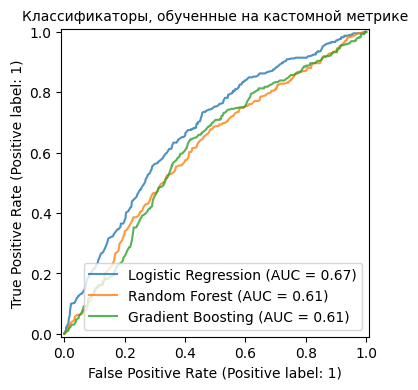

In [152]:
fig, ax = plt.subplots(figsize=(6, 4))

rfc_disp = RocCurveDisplay.from_estimator(log_reg_clf_custom, X_test, y_test, ax=ax, alpha=0.8, name="Logistic Regression")
rfc_disp = RocCurveDisplay.from_estimator(random_forest_clf_custom, X_test, y_test, ax=ax, alpha=0.8, name="Random Forest")
rfc_disp = RocCurveDisplay.from_estimator(grad_boost_clf_custom, X_test, y_test, ax=ax, alpha=0.8, name="Gradient Boosting")

plt.title('Классификаторы, обученные на кастомной метрике', fontsize=10)
plt.show()

**Шаг 2.**

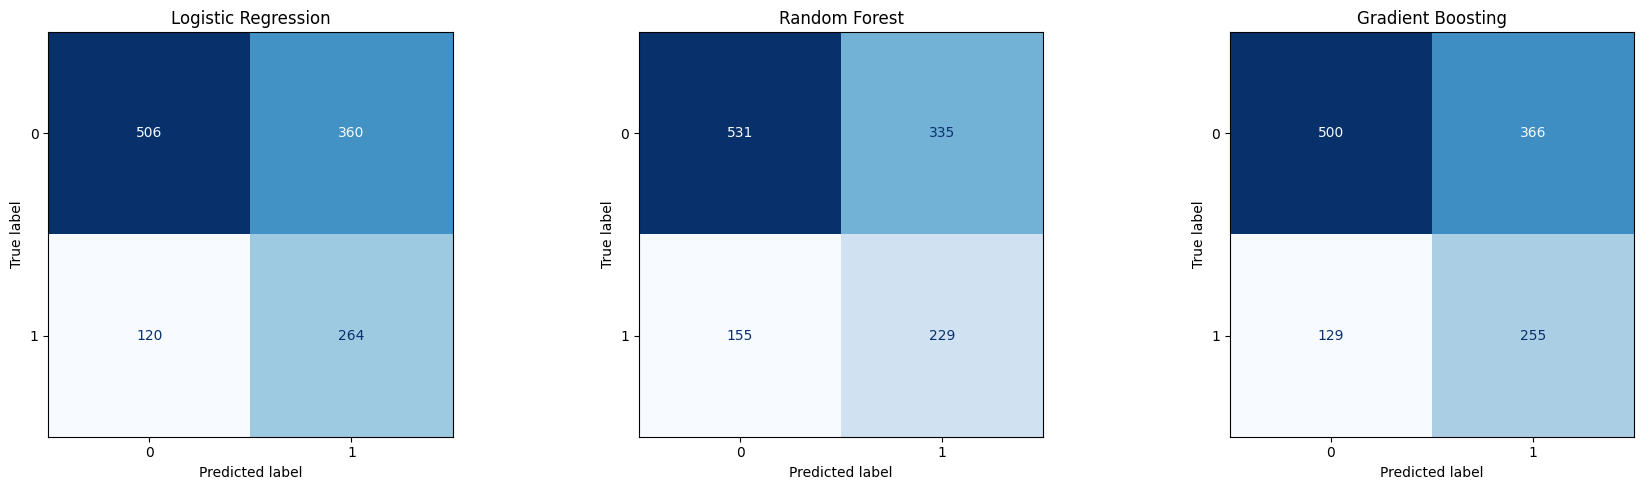

In [154]:
models = {
    'Logistic Regression': log_reg_clf,
    'Random Forest': random_forest_clf,
    'Gradient Boosting': grad_boost_clf
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (name, model) in zip(axes, models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
    ax.set_title(name)

plt.tight_layout()
plt.savefig("conf_matrix.png", dpi=300, bbox_inches='tight')
plt.show()


**Промежуточный вывод:** все три модели плохо справляются с обнаружением положительного класса, то есть с правильным нахождением минорного класса. В данном случае стоит выделить `Random Forest`, как модель, которая меньше всего делает ошибки вида `False Negative`.

**Шаг 3.**

In [60]:
avg_tune_logreg = (results_acc.loc[results_acc['Метод'] == 'Logistic Regression', 'Время тюнинга'].values[0] + results_f1.loc[results_acc['Метод'] == 'Logistic Regression', 'Время тюнинга'].values[0] + results.loc[results_acc['Метод'] == 'Logistic Regression', 'Время тюнинга'].values[0]) / 3
avg_tune_rand_forest = (results_acc.loc[results_acc['Метод'] == 'Random Forest', 'Время тюнинга'].values[0] + results_f1.loc[results_acc['Метод'] == 'Random Forest', 'Время тюнинга'].values[0] + results.loc[results_acc['Метод'] == 'Random Forest', 'Время тюнинга'].values[0]) / 3
avg_tune_grad_boost = (results_acc.loc[results_acc['Метод'] == 'Gradient Boosting', 'Время тюнинга'].values[0] + results_f1.loc[results_acc['Метод'] == 'Gradient Boosting', 'Время тюнинга'].values[0] + results.loc[results_acc['Метод'] == 'Gradient Boosting', 'Время тюнинга'].values[0]) / 3

all_classification_time = pd.DataFrame([
    {
        'Модель': 'Logistic Regression',
        'Среднее время тюнинга': avg_tune_logreg
    },
    {
        'Модель': 'Random Forest',
        'Среднее время тюнинга': avg_tune_rand_forest
    },
    {
        'Модель': 'Gradient Boosting',
        'Среднее время тюнинга': avg_tune_grad_boost
    }
])
all_classification_time

,Модель,Среднее время тюнинга
0,Logistic Regression,NaN
1,Random Forest,6.705667
2,Gradient Boosting,84.555333


**Итоговый вывод:**

## Пункт 9.

В качестве дополнительного метода классификации мы решили выбрать сразу два метода. <br>
1) **`LightGBM`** - нельзя было не попробовать классику на нашей задаче. Этот метод хорош как минимум из-за оптимизации использования памяти и скорости обучения, что, наверное, для нас не является большим преимуществом, так как датасет небольшой.
2) **`kNN + HNSW`** - захотелось проверить в нашем исследовании недавно пройденный на МО-2 метод быстрого поиска ближайших соседей. Так как это уже не такая классика, как разновидности бустингов, остановимся на описании подробнее. Основная идеи данного иерархического графого метода (`hierarchical navigable small world`) заключается в том, что для нашего датасета "объекты-признаки" можно определенным образом построить удобный и репрезентативный граф, который будет удовлетворять следующим свойствам:
    * Cтепени вершин маленькие (то есть в одну вершину не идет сразу много ребер)
    * Выполнено свойство маленького мира (то есть расстояние между парами вершин в среднем небольшие)
    * отражены основные метрические свойства <br>
3) **Описание `kNN + HNSW` метода:** В обычном `NSW` методе граф строится с помощью метода `AddNode`, случайным образом выбирается вершина в графе, а потом с помощью `GreedySearch` подхода мы доходим по графу до ближайшего объекта к некому новому объекту, k ближайших соседей которого надо найти. В случае **`HNSW`** делается предположение, что обычно графы состоят из разных компонент связности, которые слабо соединены между собой. И цель иерархического метода как можно быстрее перейти в нужны компоненту связности (то есть ту, где находится исследуемая вершина). Для этого строится несколько графов разной степени детализации. <br>
Допустим, степень детализации увеличивается сверху вниз. Тогда все вершины, которые есть на более низних уровнях, также присутствуют на более высоких, но ребра всегда строятся заново, без оглядки на вид графов предыдущих слоев. <br>
За счет того, что на самом высоком уровне остается небольшое количество случайных исходных вершин, дойти от старта до ближайшего соседа к интересующей нас точке можно **гораздо быстрее**. В этом и заключается **преимущество метода**. <br>
В качестве недостатка можно выделить тот факт, что граф надо построить таким образом, чтобы расстояние между объектами действительно было репрезентативным. То есть расстояние должно учитывать разные масштабы признаков, наличие корреляций между ними, цель исследования и прочее. Тут сразу вспоминается `расстояние Махаланобиса`, которое учитывается много из этого, но все равно сложность правильного построения графа может быть **недостатком этого метода** по сравнению с рассмотренными ранее. Также **в качестве недостатка** можно выделить сравнительно небольшую гибкость в подборе гиперпараметров и отсутствия удобного принципа подбора гиперпараметров (то есть степень детализации на каждом уровне, количество уровней). <br>
В процессе работы мы выявили еще один недостаток, но решили оставить это в исследовании, так как в любом случае способ классификации рабочий, а кто не ошибается - тот не учится. **Последний недостаток,** о котором хочется сказать: для `HNSW` сложно разделять объекты на классы, если они имеют недостаточно разнообразные признаки. Это как раз наш случай, ведь в наших данных очень много бинарных переменных. Так что лучше применять `HNSW` на действительно больших датасетах, для чего он и создавался.

**`LightGBM`**

In [52]:
# для чистоты эксперимента дополнительно выделим валидационную выборку
X_val, X_test_new, y_val, y_test_new = train_test_split(X_test, y_test, train_size=0.7, random_state=666)

In [53]:
def objective(trial):
    boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss'])
    extra_trees = trial.suggest_categorical('extra_trees', [True, False])
    
    params = {
        'boosting_type': boosting_type,
        'extra_trees': extra_trees,
        'max_bin': trial.suggest_int('max_bin', 64, 512),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.2, log=True),
        'num_iterations': trial.suggest_int('num_iterations', 100, 1000),
        'num_leaves': trial.suggest_int('num_leaves', 10, 256),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        'verbosity': -1,
        'random_state': 666,
        'n_jobs': -1,
    }

    model = LGBMClassifier(**params)
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_val)
    accuracy = accuracy_score(y_val, predictions)
    return accuracy

In [54]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

[I 2025-06-03 22:44:19,625] A new study created in memory with name: no-name-cc24cd7b-4671-4cb9-bb6d-d28e4b08396b


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-03 22:44:19,890] Trial 0 finished with value: 0.672 and parameters: {'boosting_type': 'gbdt', 'extra_trees': False, 'max_bin': 174, 'learning_rate': 0.03783145943502368, 'num_iterations': 149, 'num_leaves': 139, 'min_data_in_leaf': 48}. Best is trial 0 with value: 0.672.
[I 2025-06-03 22:44:20,187] Trial 1 finished with value: 0.6777142857142857 and parameters: {'boosting_type': 'dart', 'extra_trees': False, 'max_bin': 99, 'learning_rate': 0.004273922232483636, 'num_iterations': 145, 'num_leaves': 115, 'min_data_in_leaf': 11}. Best is trial 1 with value: 0.6777142857142857.
[I 2025-06-03 22:44:20,506] Trial 2 finished with value: 0.6822857142857143 and parameters: {'boosting_type': 'goss', 'extra_trees': True, 'max_bin': 474, 'learning_rate': 0.03132962720778214, 'num_iterations': 989, 'num_leaves': 62, 'min_data_in_leaf': 26}. Best is trial 2 with value: 0.6822857142857143.
[I 2025-06-03 22:44:20,958] Trial 3 finished with value: 0.6742857142857143 and parameters: {'boostin

In [55]:
print("Лучшие параметры:", study.best_params)
print("Лучший accuracy:", round(study.best_value, 3))

Лучшие параметры: {'boosting_type': 'gbdt', 'extra_trees': False, 'max_bin': 96, 'learning_rate': 0.003184788187578631, 'num_iterations': 311, 'num_leaves': 14, 'min_data_in_leaf': 75}
Лучший accuracy: 0.685


**`kNN + HNSW`**

In [56]:
class HNSWKNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, k=5, space='l2', ef=200, M=16, ef_construction=100):
        self.k = k
        # space, ef, M, ef_construction - гиперпараметры, о сложности подбора которых мы упоминали ранее
        self.space = space # тут как раз задаем расстояние, его можно поменять, например, на cosine
        self.ef = ef
        self.M = M
        self.ef_construction = ef_construction
        self.index = None
        self.labels = None
        self.dim = None

    def fit(self, X, y):
        self.dim = X.shape[1]
        self.labels = np.array(y)
        self.index = hnswlib.Index(space=self.space, dim=self.dim)
        self.index.init_index(max_elements=len(X), ef_construction=self.ef_construction, M=self.M)
        self.index.add_items(X, self.labels)
        self.index.set_ef(self.ef)
        return self

    def predict(self, X):
        indices, _ = self.index.knn_query(X, k=self.k)
        neighbor_labels = self.labels[indices]
        predictions = mode(neighbor_labels, axis=1).mode.flatten()
        return predictions

    def predict_proba(self, X):
        indices, _ = self.index.knn_query(X, k=self.k)
        neighbor_labels = self.labels[indices]
        probs = np.mean(neighbor_labels == 1, axis=1)
        return np.vstack((1 - probs, probs)).T

### Подбор гиперпараметров:

In [57]:
param_grid = {'space': ['l2', 'cosine', 'ip'], 'k': [1, 2], 'ef': [100, 200], 'M': [8, 16, 32, 64]}

grid = GridSearchCV(HNSWKNNClassifier(), param_grid, scoring='accuracy', cv=5)
grid.fit(X_train, y_train)
print("Оптимальные гиперпараметры:", grid.best_params_)
print("Лучшее значение accuracy:", round(grid.best_score_, 3))

Оптимальные гиперпараметры: {'M': 8, 'ef': 100, 'k': 2, 'space': 'l2'}
Лучшее значение accuracy: 0.687


## Пункт 10.

В качестве дополнительного анализа посмотрим, как модель `LightGBM` ранжирует признаки по важности: